In [130]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import config 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
# from copula import *
import plotly.express as px
# import ndtest                      
import warnings
warnings.filterwarnings("ignore")

class Macro: 
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = 'SP500','BAMLC0A4CBBBEY','BAMLC0A1CAAAEY','USALOLITONOSTSAM','DRTSCILM','DRTSCIS','IPMAN','INDPRO','M1V','M2V','MABMM301USA189S', 'WM2NS','QUSR368BIS','UMCSENT','COMREPUSQ159N','W398RC1A027NBEA','FEDFUNDS','PCETRIM12M159SFRBDAL','DGS10','DGS2','EFFR','DGS30','AAA','DBAA','BAMLH0A3HYC','BAMLH0A0HYM2','QBPBSTAS', 'TREAST', 'TREAS1T5','TREAS5T10','TREAS15', 'TCU','ICSA','AWHMAN','NEWORDER','AMTMNO','PERMIT','WEI', 'WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL', 'WORAL',"WALCL", "WCURCIR", 'WDTGAL', 'WLRRAL','GCEC1','PCEC96','GDPC1','FRBATLWGTUMHWG83O','PCE','UNRATE','TDSP','PALLFNFINDEXQ','TEMPHELPS','JTSHIR','PSAVERT','FYFSGDA188S','CPILFESL'
    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY","XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
                            "GDXJ","MBB", "UUP","IIGD","PINK","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
                           '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
                           'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLC','XLB','BIL',
                           'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
                           'SPDW','XTN','SPMB','SLYV','EFIV','EFAX','MDYV'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]


In [131]:
i = Macro(0, '2010-01-01','2023-05-01')

In [132]:
inst = i.macro()
data = inst[1]

In [143]:
tickers = ['T10Y2Y','BAMLC0A4CBBBEY','BAMLC0A1CAAAEY',
        'DGS10','DGS2','EFFR','DGS30', 
        'DBAA','BAMLH0A3HYC','BAMLH0A0HYM2','WEI',
          'WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL', 'WORAL',"WALCL", "WCURCIR", 'WDTGAL','WLRRAL','SP500']


start = '1990-01-02'
end = dt.datetime.now()
fwd = i.dataframe(tickers, data.set_index("DATE"), start, end)
fwd['WEI'] = fwd['WEI'].shift(3)    # shift it 3 days because this actually comes out on Thursday, not Saturday

### h.4.1 data comes out every Wednesday, but will shift to Thursday to match frequency of WEI

fwd['WSHOTSL'] = fwd['WSHOTSL'].shift(1)     # total face value of U.S. Treasury securities held by the Federal Reserve
fwd['WSHOMCB'] = fwd['WSHOMCB'].shift(1)     # The current face value of mortgage-backed obligations held by Fed
fwd['WSHOFADSL'] = fwd['WSHOFADSL'].shift(1) # The current face value of federal agency obligations
fwd['WALCL'] = fwd['WALCL'].shift(1)         # Total Assets (Less Eliminations from Consolidation):
fwd['WCURCIR'] = fwd['WCURCIR'].shift(1)     # Currency in circulation includes paper currency and coin held both by the public and in the vaults of depository institutions. 
fwd['WLCFLL'] = fwd['WLCFLL'].shift(1)       # Loans is the sum of "Primary credit," "Secondary credit," "Seasonal credit," "Term Asset-Backed Securities Loan Facility," and "Other credit extensions".
fwd['WORAL'] = fwd['WORAL'].shift(1)         # Repurchase agreements reflect some of the Federal Reserve's temporary open market operations.
fwd['10s2s'] = fwd['DGS10'] - fwd['DGS2']
fwd['Corporate Spread'] = fwd['BAMLC0A4CBBBEY']-fwd['BAMLC0A1CAAAEY']
fwd['2sFedFunds'] = fwd['DGS2'] - fwd['EFFR']
fwd1 = fwd.reset_index()

### Weekly Resample - Thursday

fwd2 = fwd.resample('W-Thu').last().reset_index()
fwd_rates = fwd['2002':'2022'].dropna()

fwd2 = fwd2.rename(columns={'BAMLH0A3HYC':'BofA CCC US HY OAS', 'BAMLH0A0HYM2':'BofA US HY OAS', 'BAMLC0A4CBBBEY':'BofA BBB US Corp Eff Yield', 
                     'BAMLC0A1CAAAEY':'BofA AAA US Corp Eff Yield', 
                     'WSHOTSL': 'SOMA', 'WSHOMCB': 'MBS Fed',
                     'WSHOFADSL': 'Fed Agencies', 'WLCFLL': 'Loans','WORAL': 'Repos Fed',
                     'WDTGAL': 'TGA','WLRRAL':'RRP'})


fwd2 = fwd2.dropna().set_index("DATE")
pd.set_option('display.max_columns', None)
fwd_pct = fwd2.pct_change()
fwd2

ticker,BofA AAA US Corp Eff Yield,BofA BBB US Corp Eff Yield,BofA US HY OAS,BofA CCC US HY OAS,DBAA,DGS10,DGS2,DGS30,EFFR,SP500,WALCL,WCURCIR,TGA,WEI,Loans,RRP,Repos Fed,Fed Agencies,MBS Fed,SOMA,10s2s,Corporate Spread,2sFedFunds
DATE,,,,,,,,,,,,,,,,,,,,,,,
2014-01-16,2.81,3.79,3.88,7.23,5.18,2.86,0.41,3.77,0.07,1845.89,4071528.0,1229.185,87926.0,1.47,115.0,156266.0,0.0,54911.0,1525204.0,2220953.0,2.45,0.98,0.34
2014-01-23,2.76,3.75,3.92,7.29,5.11,2.79,0.39,3.68,0.07,1828.46,4097914.0,1226.257,96724.0,1.55,121.0,201954.0,0.0,54911.0,1539467.0,2231430.0,2.40,0.99,0.32
2014-01-30,2.71,3.74,4.12,7.59,5.08,2.72,0.36,3.65,0.07,1794.19,4102138.0,1224.839,95632.0,2.07,127.0,195428.0,0.0,54911.0,1532224.0,2243176.0,2.36,1.03,0.29
2014-02-06,2.73,3.77,4.21,7.78,5.13,2.73,0.33,3.67,0.07,1773.43,4109285.0,1228.635,77423.0,1.97,103.0,196114.0,0.0,51411.0,1532231.0,2252973.0,2.40,1.04,0.26
2014-02-13,2.72,3.72,4.07,7.59,5.12,2.73,0.32,3.70,0.06,1829.83,4119474.0,1231.756,32564.0,1.81,101.0,192072.0,0.0,51411.0,1532242.0,2261099.0,2.41,1.00,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-14,4.49,5.41,3.47,9.03,5.49,3.92,4.37,4.03,5.33,4719.55,7739566.0,2330.909,630618.0,1.99,129574.0,1152232.0,7.0,2347.0,2446901.0,4809734.0,-0.45,0.92,-0.96
2023-12-21,4.53,5.41,3.41,8.73,5.53,3.89,4.33,4.03,5.33,4746.75,7724063.0,2331.997,732721.0,1.88,137262.0,1124202.0,0.0,2347.0,2443492.0,4792329.0,-0.44,0.88,-1.00
2023-12-28,4.49,5.34,3.32,8.57,5.46,3.84,4.26,3.98,5.33,4783.35,7712781.0,2340.523,713064.0,2.30,141785.0,1165574.0,0.0,2347.0,2431773.0,4790547.0,-0.42,0.85,-1.07


Monetary Policy and SPX Levels

<Axes: xlabel='DATE'>

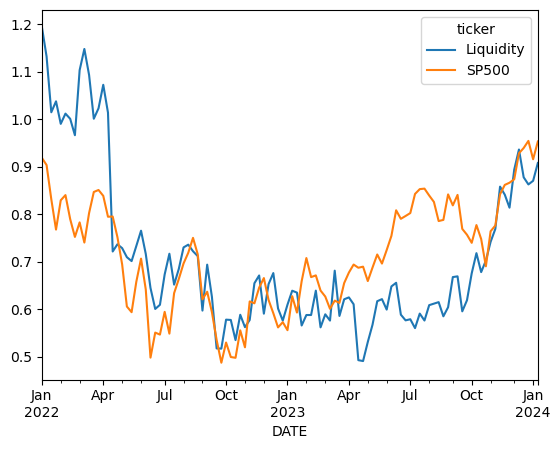

In [144]:
fwd2['Liquidity'] = fwd2['SOMA'] - fwd2['TGA'] - fwd2['RRP']
fed = fwd2[['Liquidity','SOMA','RRP','TGA','SP500','WCURCIR']]['2019':]
fed_pct = fed.pct_change().dropna()
fed_norm = (1 + fed_pct).cumprod() - 1
fed_norm[['Liquidity','SP500']]['2022':].plot()

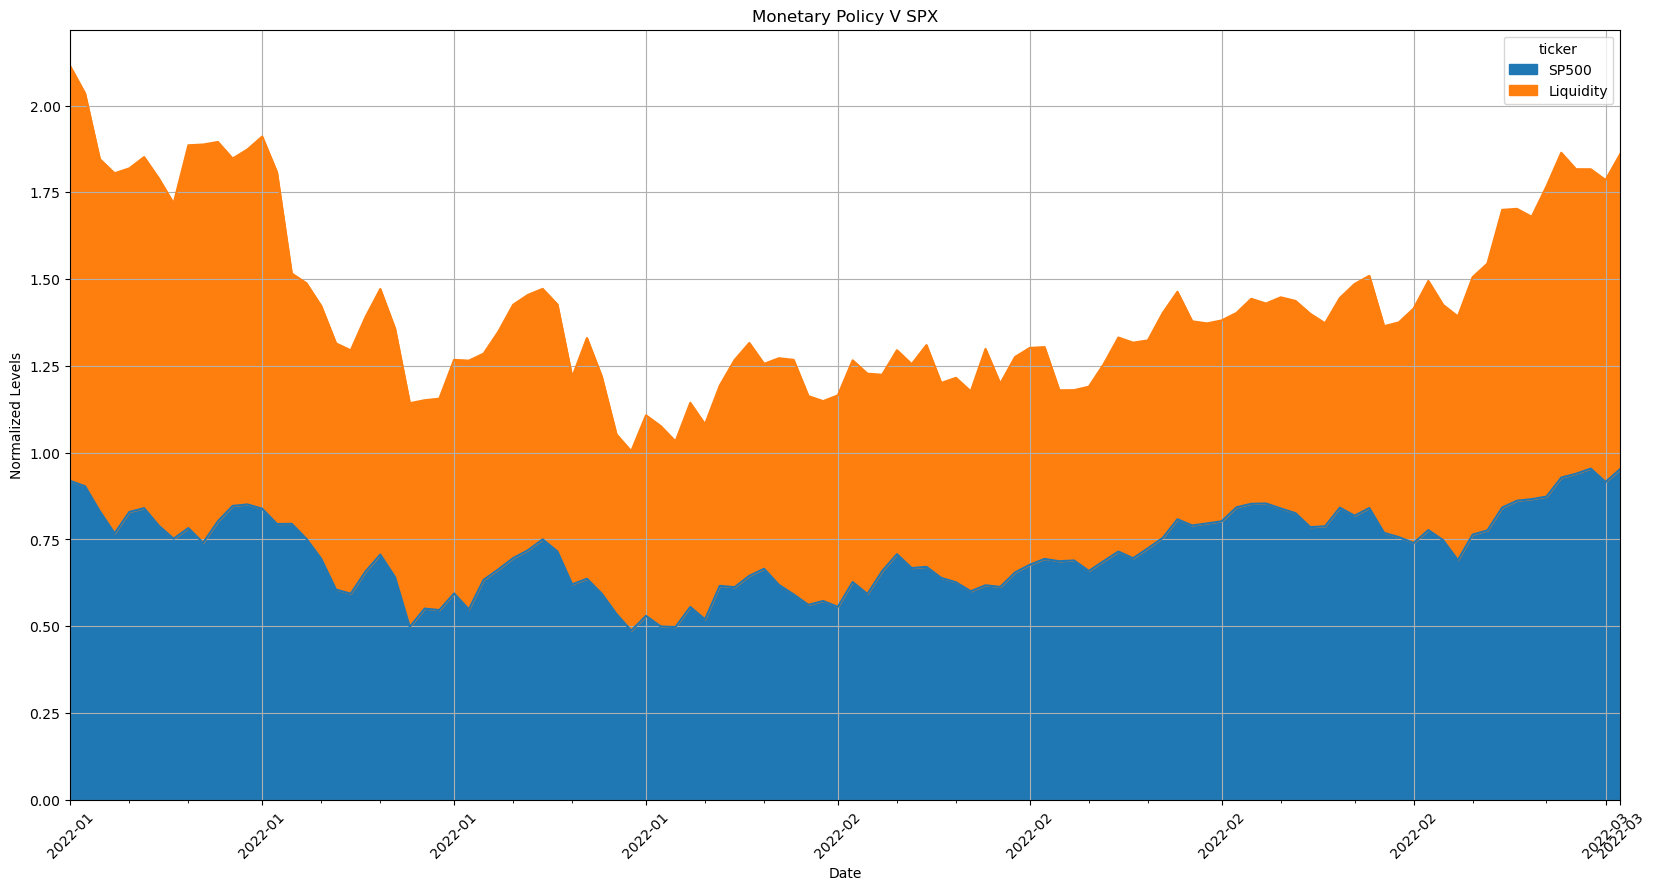

In [145]:
ax = fed_norm[["SP500","Liquidity"]]['2022':].plot.area(figsize=(20,10), grid=True, title="Monetary Policy V SPX",
                          xlabel='Date', rot=45,
                          ylabel="Normalized Levels") 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fed_norm['2022':].index)))


In [146]:
fed_norm['Last Week Liquidity'] = fed_norm.Liquidity.shift(1)

fig = px.line(fed_norm['2022':].dropna().reset_index(), x="DATE", y=["Last Week Liquidity","SP500"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Monetary Policy v. SPX')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Normalized Levels"
)


In [147]:
fig = px.line(fed_norm['2012':].dropna().reset_index(), x="DATE", y=["Liquidity","SP500"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Monetary Policy v. SPX')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Normalized Levels"
)

In [148]:
fig = px.line(fed['2015':].dropna().reset_index(), x="DATE", y=["TGA","RRP"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='RRP Runoff')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Normalized Levels"
)

Inflation

In [189]:
tickers = ['PCE','PCEC96','CPILFESL']
start = '1990-01-02'
end = dt.datetime.now()
pce = i.dataframe(tickers, data.set_index("DATE"), start, end)
inflation = pce/pce.shift(12)-1
inflation = inflation*100

In [199]:
core = inflation[['CPILFESL']]['2017':].reset_index().dropna()
fig = px.line(core, x="DATE", y=["CPILFESL"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='CORE CPI y/y')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Core CPI y/y Pct Change")

In [200]:
inf = inflation.dropna().reset_index()

In [201]:
fig = px.line(inf, x="DATE", y=["PCE","CPILFESL"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Inflation y/y')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="y/y Pct Change"
)

<Axes: xlabel='DATE'>

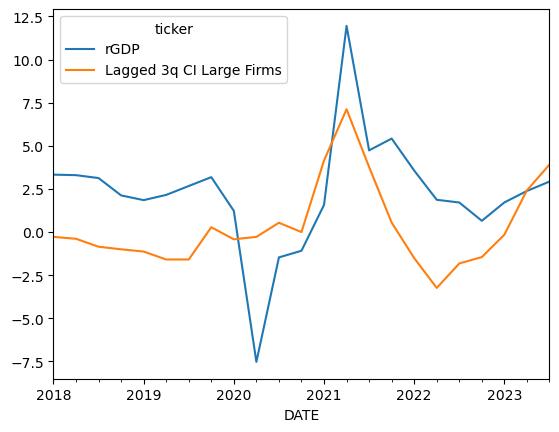

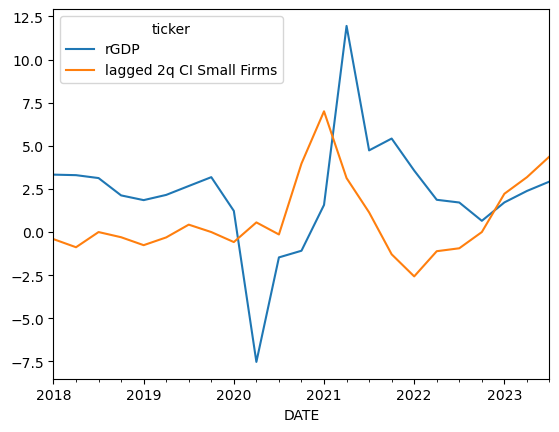

In [310]:
# rgdp = growth[['GDPC1']].dropna()
growth = growth.rename(columns = {'DRTSCILM':"C&I Tightening Standards: Large and MM"})
rgdp = growth[['DRTSCIS','GDPC1','C&I Tightening Standards: Large and MM']].dropna()
rgdp['CI Small Firms'] = rgdp['DRTSCIS'] / 10
rgdp['CI Large Firms'] = rgdp['C&I Tightening Standards: Large and MM'] / 10
rgdp['rGDP'] = (rgdp['GDPC1'] / rgdp['GDPC1'].shift(4)) - 1
rgdp['rGDP'] = rgdp['rGDP']*100
gip = rgdp['rGDP']
# infl_growth = inflation[['CPILFESL']].dropna()
# pd.concat([gip.dropna(), infl_growth],axis=1).dropna()
rgdp['lagged 2q CI Small Firms'] = rgdp['CI Small Firms'].shift(2)
rgdp['Lagged 3q CI Large Firms'] = rgdp['CI Large Firms'].shift(3)
rgdp[['rGDP','Lagged 3q CI Large Firms']]['2018':].plot()
rgdp[['rGDP','lagged 2q CI Small Firms']]['2018':].plot()



In [305]:
ci = growth[['C&I Tightening Standards: Large and MM']].dropna()['2019':]
fig = px.line(ci.dropna().reset_index()[['DATE','C&I Tightening Standards: Large and MM']], x="DATE", y=["C&I Tightening Standards: Large and MM"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='C&I Tightening Standards %')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Net pct of Banks Tightening Standards for C&I Loans to Large & Middle-Market Firms")

In [292]:
fig = px.line(gip.dropna().reset_index()[['DATE','rGDP']], x="DATE", y=["rGDP"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Real GDP y/y')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Real GDP YoY")

Unemployment, Wage Tracker

<Axes: xlabel='DATE'>

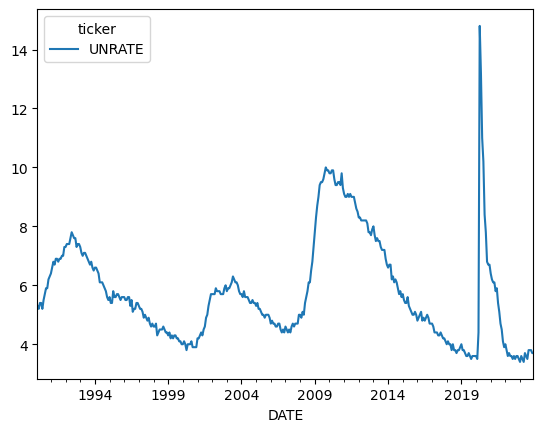

In [238]:
tickers = ['FRBATLWGTUMHWG83O','UNRATE','TEMPHELPS','JTSHIR']
start = '1990-01-02'
end = dt.datetime.now()
unrate = i.dataframe(tickers, data.set_index("DATE"), start, end)
emp = unrate[['UNRATE']]
emp.plot()

In [239]:
workforce = unrate[['FRBATLWGTUMHWG83O','JTSHIR']].dropna()
wf = workforce.rename(columns = {'FRBATLWGTUMHWG83O':'ATL Fed Wage Tracker',
                            'JTSHIR':'NFP: Hires'})
fig = px.line(wf.reset_index(), x="DATE", y=["NFP: Hires","ATL Fed Wage Tracker"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Hires and Wages')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Hires and Wages: Levels")

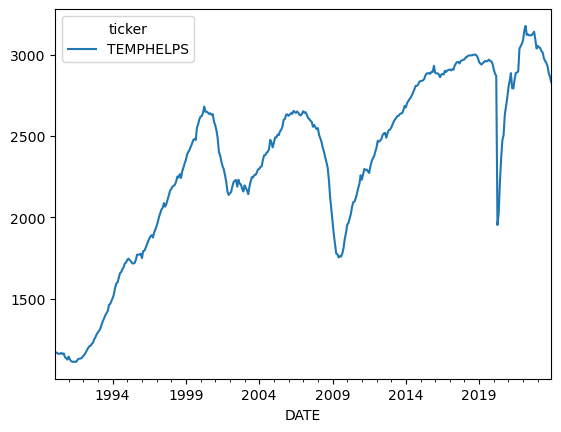

In [241]:
unrate[['TEMPHELPS']].plot()
fig = px.line(unrate.reset_index(), x="DATE", y=["TEMPHELPS"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Temporary Help Services: Good Proxy for Economic Downturn')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Temporary Help Services")